In [ ]:
from collections import namedtuple
import numpy as np 
from scipy.integrate import odeint 
import matplotlib.pyplot as plt
import random as rand
from scipy.stats import hypergeom
from tqdm import tqdm 
import csv
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
from matplotlib.colors import Normalize 
import matplotlib.colors as cls

# Apply the default theme for plotting (seaborn)
sns.set_theme()

# Is testing the bee-all and end-all of varroa eradication?
## Supplementary material 

### Isobel R. Abell, Thao P. Le, Jennifer A. Flegg, and Christopher M. Baker

Running all cells will generate the data for all figures in the manuscript (saved as csv files) and generate Figures 2 - 8 (saved as svg files). 

## Table of Contents
- [1 Within-hive dynamics](#within-hive-dynamics)
    - [1.1 Mite reproduction](#mite-reproduction)
    - [1.2 Mite death](#mite-death)
    - [1.3 Putting it together](#within-hive-code)
- [2 Testing](#testing)
    - [2.1 Code](#testing-code)
- [3 Between-hive dynamics](#between-hive-dynamics)
    - [3.1 Hive structure](#hive-structure)
    - [3.2 Between-hive movement](#between-hive-movement)
    - [3.3 Code](#between-hive-code)
- [4 Full model](#full-model)
- [5 Results](#results)
    - [5.1 Plotting single simulations](#plotting-code)
    - [5.2 Multiple simulations](#multiple-simulations)
    - [5.3 Parameter sensitivity](#parameter-sensitivity)
    - [5.4 Generating results](#generating-results)

## <a class ="anchor" id="within-hive-dynamics"></a>1 Within-hive dynamics

### <a class = "anchor" id ="mite-reproduction"></a>1.1 Mite reproduction

To model mite reproduction within a hive, we consider the number of female, fertalised mites in an hive at a given time _t_. These mites can be in one of the following compartments

- $A_i$: Adult (ith reproductive cycle)
- $B_i$: Adult in brood (ith reproductive cycle)
- Teen: immature mite (can't reproduce)
- D: Dead mite
Where $i$ denotes the current reproductive cycle of the mite. 

We assume the following in our model:
- Adults mites go through 3 reproductive cycles before dying, 
- Adults mites spend 5 days in a phoretic phase before entering the brood,
- Adults mites spend 14 days in the brood, 
- Adults mites produce 2 immature mites after their time in the brood
- Immature mites develop to adult mites in 14 days. 

We also assume there is a 5% chance a mite in the phoretic stage (compartments $A_i$ or Teen) will die on any given day (due to falling off a bee etc)

The following diagrams shows the varroa lifecycle in detail. 

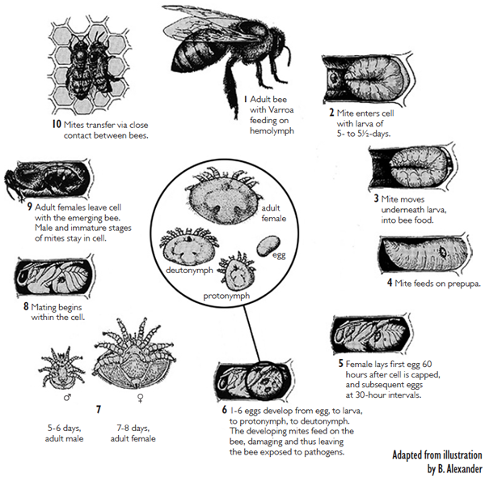

In this model, varroa reproduction this is implemented through two matrices: ``adult_matrix`` and ``teen_matrix``. For each matrix, each row represents one hive. The columns represent the various stages a mite can be in. That is, mites spend 5 days in a phoretic stage, so columns 0 to 4 represent the number of mites that have spent 0, 1, 2, 3, and 4 days in the phoretic stage respectively. We use this matrix to calculate the number of mites in each stage of the reproduction cycle, rather than storing the respective stage for each individual mite.



The function ``update_total_counts`` calculates the total number of mites in compartments $A_i$, Teen, the total number of mites and cumulative mites in a given hive. These values are used to calculate 

In [33]:
def update_total_counts(mite_dictionary):
    # iterate over hives
    for hive in range(mite_dictionary['total_hives']):
        mite_dictionary['total_A0'][hive] = sum(mite_dictionary['adult_matrix'][hive,mite_dictionary['A0_start']:mite_dictionary['A0_end']])
        mite_dictionary['total_A1'][hive] = sum(mite_dictionary['adult_matrix'][hive,mite_dictionary['A1_start']:mite_dictionary['A1_end']])
        mite_dictionary['total_A2'][hive] = sum(mite_dictionary['adult_matrix'][hive,mite_dictionary['A2_start']:mite_dictionary['A2_end']])
        mite_dictionary['total_Teen'][hive] = sum(mite_dictionary['teen_matrix'][hive,:])
        mite_dictionary['total_mites'][hive] = sum(mite_dictionary['adult_matrix'][hive,:-1]) + mite_dictionary['total_Teen'][hive]
        mite_dictionary['total_mites_out_of_brood'][hive] = mite_dictionary['total_A0'][hive] + mite_dictionary['total_A1'][hive] + mite_dictionary['total_A2'][hive] + mite_dictionary['total_Teen'][hive]
        mite_dictionary['cumulative_mites'][hive] += sum(mite_dictionary['adult_matrix'][hive,:-1])

        # if there are mites in a hive and it hasn't been previously marked as infested, mark the hive as infested
        if mite_dictionary['total_mites'][hive] and not mite_dictionary['infested_hive_flag'][hive]:
            mite_dictionary['infested_hive_flag'][hive] = 1
    
    return

 ``initialise_mite_comparments`` initialises these matrices for a $\left(\text{n}_{\text{grid}}\right)^2$ network:

In [34]:
def initialise_mite_compartments(initial_hive,n_grid):

    # assume there are initially 3 mites
    initial_mites = 3

    # total lifecycle of the adult mite = 58
    compartment_columns_adult = 58

    # total time mites spend immature
    teen_compartments = 14

    # total number of hives in our network
    total_hives = n_grid**2

    # defining elementary matrices for use later in reproduction/death calculations
    array_1_adult = np.zeros((compartment_columns_adult - 1, 1))
    array_1_teen = np.zeros((teen_compartments, 1))
    array_2_adult = np.eye(compartment_columns_adult - 1, compartment_columns_adult - 2)
    array_2_teen = np.eye(teen_compartments, teen_compartments - 1)

    e_mat_adult = np.hstack((array_1_adult, array_2_adult))
    e_mat_teen = np.hstack((array_1_teen, array_2_teen))

    # defining relevant parameters for the rest of the code
    mites_dict = {'adult_matrix': np.zeros((total_hives, compartment_columns_adult)), 
                        'teen_matrix': np.zeros((total_hives, teen_compartments)),
                        'total_mites':[0 for _ in range(total_hives)],
                        'total_mites_out_of_brood': [0 for _ in range(total_hives)],
                        'cumulative_mites':[0 for _ in range(total_hives)],
                        'total_A0':[0 for _ in range(total_hives)],
                        'total_A1':[0 for _ in range(total_hives)],
                        'total_A2':[0 for _ in range(total_hives)],
                        'total_Teen':[0 for _ in range(total_hives)],
                        'total_hives': total_hives,
                        'n_grid': n_grid,
                        'adult_compartment_columns': compartment_columns_adult,
                        'teen_compartment_columns': teen_compartments,
                        'A0_start': 0,
                        'A0_end': 4,
                        'A1_start': 19,
                        'A1_end': 23,
                        'A2_start': 38,
                        'A2_end': 42,
                        'B0_end_index': 18,
                        'B1_end_index': 37,
                        'B2_end_index' : 56,
                        'teen_compartments': 14,
                        'dead_hive_flag': [0 for _ in range(total_hives)],
                        'infested_hive_flag': [0 for _ in range(total_hives)],
                        'total_mites_when_testing_starts': [0 for _ in range(total_hives)],
                        'el_mat_adult': e_mat_adult,
                        'el_mat_teen': e_mat_teen 
                    }
    
    # seeding a mite infestation (3 mites - random point in reproductive cycle)
    # phoretic adult indices
    phoretic_columns = list(range(mites_dict['A0_start'], mites_dict['A0_end']+1)) + list(range(mites_dict['A1_start'], mites_dict['A1_end']+1)) + list(range(mites_dict['A2_start'], mites_dict['A2_end']+1))

    # choosing three random points for mites to be initialised to 
    indices = np.random.choice(phoretic_columns, initial_mites) 
    #*** NEED TO CONVERT TO NUMPY.RANDOM FOR SEED TO WORK****

    # putting mites in the adult matrix
    for i in indices:
        mites_dict['adult_matrix'][initial_hive, i] = 1

    # updating total_counts
    update_total_counts(mites_dict)

    return mites_dict

### <a class = "anchor" id="mite-death"></a> 1.2 Mite death

We implement stochastic mite death into the model by assuming over the mite's lifetime it has a $5\%$ chance of dying (e.g. due to falling off a bee). Using this assumption, we can calculate a mite's daily probability of dying as follows: 

- Let $d$ be the daily probability of dying, $\tau$ the length of time a mite spends outside of the brood (i.e. with a chance to randomly die) and $p$ the probability a mite dies over its lifetime. 
- Therefore, the daily probability of surviving is given by: $$(1-d)$$
- Using this, we can calculate the probability of surviving over a mite's lifetime: $$ (1-d)^{\tau}$$
- Hence the mite's probability of randomly dying is given by: $$ 1 - (1-d)^{\tau}$$
- Given we know the probability a mite dies over its lifetime ($p$), we can rearrange to calculate the daily probability a mite dies: $$d = 1 - (1 - p)^{\frac{1}{\tau}}$$

We assume the mites spend 29 days in the phoretic stage (total over immature and adult stages of life), and we assume each mite has $5\%$ chance of dying over this lifetime, we calculate the daily probability of dying as: $$ d = 1 - (0.95)^{\frac{1}{29}} \approx 0.00177$$


The function ``mite_death_stochastic`` determines how many mites in each compartment die at a given time-step. 

In [35]:
def mite_death_stochastic(mite_dictionary, hive):
    # we assume 5% chance mites die over their lifetime
    # this corresponds to 0.177% chance of dying each day
    prob_dying_per_day = 0.00177

    # list of relevant indices in adult matrix 
    adult_indices = list(range(mite_dictionary['A0_start'], mite_dictionary['A0_end']+1)) + list(range(mite_dictionary['A1_start'], mite_dictionary['A1_end']+1)) + list(range(mite_dictionary['A2_start'], mite_dictionary['A2_end']+1))

    # dead adult mites 
    for i in adult_indices:
        move_dead_mites(mite_dictionary, 'adult_matrix', prob_dying_per_day, hive, i)

    # dead immature mites 
    for j in range(mite_dictionary['teen_compartments']):
        move_dead_mites(mite_dictionary, 'teen_matrix', prob_dying_per_day, hive, j)
    return 

# calculating prop of mites that die and then moving relevant mites in matrix 
def move_dead_mites(mite_dict, matrix_name, prop, hive, comp):
    # total mites in a column comp for row hive 
    total_mites = mite_dict[matrix_name][hive,comp]

    # weird bug, total mites coming out as floats 
    if int(total_mites) != total_mites:
        flag = 1

    # calculate number of mites to remove from each column of the matrix 
    mites_dead_per_comp = [np.random.random() < prop for _ in range(int(total_mites))]
    mites_dead = sum(mites_dead_per_comp)
    # mites_dead = sum([rand.random() < prop for _ in range(int(total_mites))])
    if mites_dead:
        # move mites out of living compartments and into dead compartment 
        mite_dict[matrix_name][hive,comp] -= mites_dead
        mite_dict['adult_matrix'][hive,-1] += mites_dead
    return 

The function ``dead_hive`` sets the number of mites in each compartment to 0 for a given hive. This is due to elimination after a positive test result. 

In [36]:
def dead_hive(hive_index, mites_d):
    
    # set all mite values in a dead hive to 0
    mites_d['adult_matrix'][hive_index,:] = np.zeros((1,mites_d['adult_compartment_columns']))
    mites_d['teen_matrix'][hive_index,:] = np.zeros((1,mites_d['teen_compartment_columns']))
    
    return 

### <a class = "anchor" id="within-hive-code"></a> 1.3 Putting it together 

`mite_reproduction_death` captures the total within-hive dynamics of the mites. That is, for each hive it models the random death of mites and then the reproduction of mites (to ensure mites do not both enter the brood and die in the same timestep). After this it updates the total mite counts. 

In [37]:
def mite_reproduction_death(mite_dictionary, position_matrix):
    n_grid = mite_dictionary['n_grid']
    total_hives = mite_dictionary['total_hives']

    for hive in range(total_hives):
        
        # if hive alive and there are mites there 
        if (not mite_dictionary['dead_hive_flag'][hive]) and mite_dictionary['total_mites'][hive]:
            # mite death for adults and immature mites
            mite_death_stochastic(mite_dictionary, hive)

            # mite reproduction
            # mites born 
            B0_end_index = mite_dictionary['B0_end_index']
            B1_end_index = mite_dictionary['B1_end_index']
            B2_end_index = mite_dictionary['B2_end_index']
            
            new_teens = 2*mite_dictionary['adult_matrix'][hive, B0_end_index] + 2*mite_dictionary['adult_matrix'][hive, B1_end_index] + 2*mite_dictionary['adult_matrix'][hive, B2_end_index]

            # moving mites in reproduction cycle
            mite_dictionary['adult_matrix'][hive, -1] += mite_dictionary['adult_matrix'][hive,-2]
            for i in range(2, mite_dictionary['adult_compartment_columns']):
                mite_dictionary['adult_matrix'][hive, -i] = mite_dictionary['adult_matrix'][hive, -(i+1)]

            # immature mites moving to adult matrix 
            new_adults = mite_dictionary['teen_matrix'][hive, -1]
            for i in range(1, mite_dictionary['teen_compartment_columns']):
                mite_dictionary['teen_matrix'][hive, -i] = mite_dictionary['teen_matrix'][hive, -(i+1)]

            # initial mite numbers for adult and teens
            mite_dictionary['adult_matrix'][hive, 0] = new_adults
            mite_dictionary['teen_matrix'][hive, 0] = new_teens
        
        # if hive dead
        elif mite_dictionary['dead_hive_flag'][hive]:
            dead_hive(hive, mite_dictionary)

    # update total counts for each hive
    update_total_counts(mite_dictionary)

    return

## <a class = "anchor" id='testing'></a> 2 Testing 

Under an elimination strategy for varroa mite, we assume a hive is eliminated once it returns positive for varroa mite. 

We make the following assumptions about testing:
- Testing (alcohol wash) occurs every 16 weeks,
- An alcohol wash samples approximately 300 bees out of 40,000 from the hive, 
- 1 alcohol wash removes 70-80% of mites from sampled bees (we assume 70% test sensitivity) and 3 alcohol washes remove 90% of mites from sampled bees. 
- Testing has 100% specificity, that is there are no false positives. If a mite is detected, we assume it is a varroa mite. 

We define a positive test as one mite detected. Using this, we can calculate the probability of a positive test results as follows: 

- The probability of detecting one mite on one bee is given by:
$$ \min\left\{\text{sensitivity} \times \frac{\text{total mites}}{\text{total bees}}, 1\right\} $$

- Therefore, the probability of detecting no mites on one bee is given by:
$$ 1 - \min\left\{\text{sensitivity} \times \frac{\text{total mites}}{\text{total bees}}, 1\right\} $$

- From this, the probability of detecting no mites on samples bees is given by:
$$ \left(1 - \min\left\{\text{sensitivity} \times \frac{\text{total mites}}{\text{total bees}}, 1\right\}\right)^{\text{sampled bees}} $$

- Therefore, the probability of detecting at least one mite on sampled bees is given by: 
$$ 1 - \left(1 - \min\left\{\text{sensitivity} \times \frac{\text{total mites}}{\text{total bees}}, 1\right\} \right)^{\text{sampled bees}} $$

Therefore, assuming 90% testing sensitivity and that 300 out of 40,000 bees are sampled, the probability of successful test $(P(X\geq1))$ is given by: 
$$ Pr(X\geq 1) = 1 - \left(1 - \min\left\{0.9\frac{\text{total}(t)}{40000}, 1\right\} \right)^{300} $$
where $\text{total}(t)$ is the total number of mites in a hive at time $t$.

`testing_success` calculates if testing has been successful given the total number of mites on day $t$



In [38]:
def testing_success(total_mites_t, test_sensitivity):
    # return 1 if positive test
    # return 0 if negative test
    # Assumes positive test if at least one mite

    total_bees = 40000
    bees_in_wash = 300

    avg_mites_per_bee = total_mites_t / total_bees
    # print(avg_mites_per_bee)
    
    avg_fallen_mites_per_bee = test_sensitivity * avg_mites_per_bee

    pr_detection = 1 - (1 - np.min([avg_fallen_mites_per_bee, 1]))**bees_in_wash
    
    r = np.random.random()

    if r < pr_detection:
        # success
        return 1
    
    # failure
    return 0

### <a class = "anchor" id='testing-code'></a> Code
`test_managed_bees` implements the testing strategy in the model. Note, testing does not start until `testing_start`, which denotes the time from the first varroa mite infestation to the time it was first detected (and hence when regular testing starts).

In [39]:
def test_managed_bees(t, mite_d, position_matrix, testing_days, testing_start, test_sensitivity, eliminated_hives):
    if t - testing_start >=0: 
        # record the number of mites in each hive when we start testing
        if t - testing_start == 0:
            update_total_counts(mite_d)
            mite_d['total_mites_when_testing_starts'] = mite_d['total_mites'].copy()

        # implement testing on testing days
        if (t-testing_start) % testing_days == 0:
            n = mite_d['n_grid']
            total_hives = mite_d['total_hives']
            for hive in range(total_hives):        
                # print(t)
                mites_out_of_brood = mite_d['total_A0'][hive] + mite_d['total_A1'][hive] + mite_d['total_A2'][hive] + mite_d['total_Teen'][hive]

                # testing successful 
                if testing_success(mites_out_of_brood, test_sensitivity):
                    h_i = hive//n
                    h_j = hive % n

                    # add to eliminated_hives list
                    eliminated_hives.append(hive)

                    # kill hive
                    position_matrix[h_i, h_j] = 0
                    mite_d['dead_hive_flag'][hive] = 1

    return position_matrix, eliminated_hives

## <a class = "anchor" id='between-hive-dynamics'></a> 3 Between-hive dynamics

### <a class = "anchor" id='hive-structure'></a> 3.1 Hive structure

We define the hives as existing on a grid structure and define their neighbours accordingly. In one timestep, mites have a chance to move from an infected hive to a neighbouring hive through the movement of bees and/or beekeeping equipment. 


`adjacency_matrix_grid` defines the adjacency matrix for the grid structure considered in this model. Theoretically, any adjacency matrix could be considered in our model, however we only use the grid structure. Given this adjacency matrix, `get_neighbours` determines which hives are neighbours of other hives. 

In [40]:
def adjacency_matrix_grid(n): # defines the adjacency matrix for a nxn grid
    # input: size of grid (n)
    # output: adjacency matrix for grid of size n

    # calculate total number of hives in grid
    total_n = n**2
    
    # initialise adj_matrix 
    adj_matrix = [[0]*total_n for _ in range(total_n)]
    
    # defining neighbouring indices
    def below(i):
        return i + n
    
    def above(i):
        return i - n

    def left(i):
        return i - 1
    
    def right(i):
        return i + 1

    # special cases (corners and edges rows/columns)
    # 0 (top left corner)
    adj_matrix[0][below(0)] = 1 
    adj_matrix[0][right(0)] = 1 

    # n-1 (top right corner)
    adj_matrix[n-1][below(n-1)] =1 
    adj_matrix[n-1][left(n-1)] = 1 

    # n*(n-1) (bottom left corner)
    adj_matrix[n*(n-1)][above(n*(n-1))] = 1 
    adj_matrix[n*(n-1)][right(n*(n-1))] = 1 

    #n*n - 1 (bottom right corner)
    adj_matrix[n*n - 1][above(n*n - 1)] = 1 
    adj_matrix[n*n - 1][left(n*n - 1)] = 1 

    if n>2:
        # top-most row
        for i in range(1,n-1):
            adj_matrix[i][below(i)] = 1 
            adj_matrix[i][right(i)] = 1 
            adj_matrix[i][left(i)] = 1 

        # bottom-most row 
        for i in range(n*(n-1) + 1, n*n - 1):
            adj_matrix[i][above(i)] = 1
            adj_matrix[i][right(i)] = 1 
            adj_matrix[i][left(i)] = 1 

        # left-most column
        for i in range(0,(n-1)):
            adj_matrix[n*i][above(n*i)] = 1
            adj_matrix[n*i][below(n*i)] = 1
            adj_matrix[n*i][right(n*i)] = 1

        # right-most column
        for i in range(2, n):
            adj_matrix[n*i - 1][above(n*i -1)] = 1
            adj_matrix[n*i - 1][below(n*i -1)] = 1
            adj_matrix[n*i - 1][left(n*i -1)] = 1

        # middle points
        for i in range(1,n-1):
            for j in range(1,n-1):
                adj_matrix[n*i + j][above(n*i + j)] = 1
                adj_matrix[n*i + j][below(n*i + j)] = 1
                adj_matrix[n*i + j][left(n*i + j)] = 1
                adj_matrix[n*i + j][right(n*i + j)] = 1

    return adj_matrix

# debugging
# adjacency_matrix_grid(2)

In [41]:
def get_neighbours(n):
    # input: size of grid (n)
    # output: list of indices of neighbouring hives
    if n ==1:
        return [[]]

    total_hives = n**2

    # define adjacency matrix
    adj_matrix = adjacency_matrix_grid(n)

    # finding neighbours
    neighbours = []
    i = 0
    while i < total_hives:
        # current row of adjacency matrix
        row = adj_matrix[i]

        # add hive index to neighbours if it's adjacent to current index
        neighbours.append([row[j]*j for j in range(total_hives)if row[j]*(j+1)])

        i = i + 1
    return neighbours

# debugging
# get_neighbours(adjacency_matrix_grid(2), 4)

`initialise_position_matrix` defines a matrix of ones corresponding to the "alive" status of each hive. If a hive is eliminated (due to a positive test result for varroa mite) the corresponding element of the position matrix is set to 0. 

In [42]:
def initialise_position_matrix(n_hives,n_grid):
    position_matrix = np.ones((n_grid, n_grid))
    return position_matrix

### <a class = "anchor" id='between-hive-movement'></a> 3.2 Between-hive movement

In a given timestep, mites can move from infested hives to neighbouring hives through movement of bees and/or beekeeping equipment. We assume that, on average, 1/3 of bees leave the hive on a given day. Of these bees, we assume 1% end up in a neighbouring hive.

In the model, we consider stochastic movement of mites between hives in a given timestep. We sample from a hypergeometric distribution to calculate the number of mites leaving a compartment in a hive at a given time. That is, the probability of $k$ mites leaving a compartment is given by: 
$$ Pr(X = k) = \frac{\binom{K}{k}\binom{N - K}{n - k}}{\binom{N}{n}},$$
where $K$ is the number of mites in the population (we define a "success state" as a bee carrying a mite), $n$ is the number of bees leaving the hive (the number of bees drawn in each trial) and $N$ is the total number of bees (the total population).

Given the number of mites leaving each phoretic compartment, we allocate mites to each neighbouring hive equally in their respective compartments. 

`mite_movement_stochastic` calculates the number of mites leaving each phoretic compartment for a given hive.  

In [43]:
def mite_movement_stochastic(moving_dict, current_hive, prob_movement):
    # 1/3 of bees leave hive - we assume on average 1/3 of mites in each compartment therefore leave hive 
    
    total_bee_population = 40000
    total_bees_lost = int(np.floor(prob_movement*total_bee_population/3))

    if total_bees_lost != 0:
        A0 = int(hypergeom.rvs(total_bee_population, min(int(moving_dict['total_A0'][current_hive]),total_bee_population), total_bees_lost))
        A1 = int(hypergeom.rvs(total_bee_population, min(int(moving_dict['total_A1'][current_hive]),total_bee_population), total_bees_lost))
        A2 = int(hypergeom.rvs(total_bee_population, min(int(moving_dict['total_A2'][current_hive]),total_bee_population), total_bees_lost))
        Teen = int(hypergeom.rvs(total_bee_population, min(int(moving_dict['total_Teen'][current_hive]),total_bee_population), total_bees_lost))
    else: 
        A0 = 0
        A1 = 0
        A2 = 0
        Teen = 0

    
    return [A0, A1, A2, Teen]

`mite_moving_matrix` updates the counts for hives losing mites and hives gaining mites given movement between them.

In [44]:
def mite_moving_matrix(mite_dict, in_hive, out_hive, movement_counts):
    # A0
    i = mite_dict['A0_start']
    A0_move = movement_counts[0]
    while i <= mite_dict['A0_end'] and A0_move > 0:
        if mite_dict['adult_matrix'][out_hive,i]:
            mite_dict['adult_matrix'][out_hive,i] -= 1
            mite_dict['adult_matrix'][in_hive,i] += 1
            A0_move -= 1
        else:
            i +=1 

    # A1 
    i = mite_dict['A1_start']
    A1_move = movement_counts[1]
    while i <= mite_dict['A1_end'] and A1_move > 0:
        if mite_dict['adult_matrix'][out_hive,i]:
            mite_dict['adult_matrix'][out_hive,i] -= 1
            mite_dict['adult_matrix'][in_hive,i] += 1
            A1_move -= 1
        else:
            i +=1 

    # A2
    i = mite_dict['A2_start']
    A2_move = movement_counts[2]
    while i <= mite_dict['A2_end'] and A2_move > 0:
        if mite_dict['adult_matrix'][out_hive,i]:
            mite_dict['adult_matrix'][out_hive,i] -= 1
            mite_dict['adult_matrix'][in_hive,i] += 1
            A2_move -= 1
        else:
            i +=1 

    # Teen
    i = 0
    Teen_move = movement_counts[3]
    while i < mite_dict['teen_compartment_columns'] and Teen_move > 0:
        if mite_dict['teen_matrix'][out_hive,i]:
            mite_dict['teen_matrix'][out_hive,i] -= 1
            mite_dict['teen_matrix'][in_hive,i] += 1
            Teen_move -= 1
        else:
            i +=1 
    
    return 

### <a class = "anchor" id='between-hive-code'></a> 3.3 Code

`between_hive_movement` implements the between-hive dynamics at a given timestep. It calculates how many mites are moving between hives, moves the mites between mite matrices and updates the total counts. 

In [45]:
def between_hive_movement(neighbours, managed_d, position_managed, n_grid, n_managed, prob_movement):
    # current hive = i
    for current_hive in range(n_managed):
        index_i = current_hive//n_grid
        index_j = current_hive%n_grid

        # if there's a managed hive at this index and there are mites in the hive
        if position_managed[index_i, index_j]:
            # find neighbour indices 
            hive_neighbours_all = neighbours[current_hive]
            
            # only include index if hive is still there
            hive_neighbours = [el for el in hive_neighbours_all if position_managed[el//n_grid, el%n_grid]]

            # total number of neighbours
            total_neighbours = len(hive_neighbours)

            # if there are neighbouring hives for the mites to go to 
            if total_neighbours:
                # how many mites total are leaving 
                total_mites =  mite_movement_stochastic(managed_d, current_hive, prob_movement)

                # how many mites go to each neighbour
                avg_mites = [np.floor(x/total_neighbours) for x in total_mites]
                   
                # distribute to neighbours 
                for neighbour_hive in hive_neighbours:
                    mite_moving_matrix(managed_d, neighbour_hive, current_hive, avg_mites)

    # update total mite counts after between hive movement has happened
    update_total_counts(managed_d)


    return

## <a class = "anchor" id='full-model'></a> 4 Full model

We combine the within-hive and between-hive dynamics to consider the spread of varroa mite through a network of hives across time. 

`update_total_timeseries` appends the current total_mites to timeseries to visualise the varroa mite population in each hive over time. 

In [46]:
def update_total_timeseries(mites_d, total_mites, total_mites_out_of_brood):
    for hive in range(mites_d['total_hives']):
        total_mites[hive].append(mites_d['total_mites'][hive])
        total_mites_out_of_brood[hive].append(mites_d['total_mites_out_of_brood'][hive])
    return total_mites, total_mites_out_of_brood

On a given day, we model:
- how the mites die and reproduce within the hive 
- testing for each hive 
- movement between hives 

The model runs until there are either no hives left (they have all been eliminated) or there are no mites left in the network. 

`total_model` implements the model for a single simulation instance. 

In [47]:
def total_model(initial_hive, t_end, n_managed, n_grid, neighbours,params):
   # input: 
   # initial_mites = initial number of mites in each hive (list) 
   # t_end = time endpoint for simulation
   # n = size of grid (nxn)

   # output: 
   # time simulation ended (t_end or time at which varroa mite discovered)
   # total_mites time series for each hive

   # initialise mite compartments
   managed_mites_d = initialise_mite_compartments(initial_hive, n_grid)

   # test every 16 weeks
   testing_days = params['time_between_testing']
   testing_start = params['testing_start']
   movement_prob= params['movement_prob']
   test_sensitivity = params['test_sensitivity']

   # initialise position_matrices
   position_managed_hives = initialise_position_matrix(n_managed,n_grid)
   total_mites = [[] for _ in range(n_grid**2)]
   total_mites_out_of_brood = [[] for _ in range(n_grid**2)]

# starting at day 1
   t = 1

   # start with all hives alive
   total_dead_hives = 0

   # starting with some mites
   total_mites_total_hives = 1

   # keeping track of eliminated hives
   eliminated_hives = []

   # loop over time while there are still alive hives and alive mites 
   while total_dead_hives - n_managed and total_mites_total_hives and t<t_end:
      
      # mites reproduce and die within hive
      # mite_reproduction_death(managed_mites_d, position_managed_hives)
      mite_reproduction_death(managed_mites_d, position_managed_hives)

      # hives are tested
      position_managed_hives, eliminated_hives = test_managed_bees(t, managed_mites_d, position_managed_hives, testing_days, testing_start, test_sensitivity, eliminated_hives)

      # movement between hives 
      between_hive_movement(neighbours, managed_mites_d, position_managed_hives, n_grid, n_managed, movement_prob)

      # update timeseries
      total_mites, total_mites_out_of_brood = update_total_timeseries(managed_mites_d, total_mites, total_mites_out_of_brood)

      # increment time
      t += 1

      total_dead_hives = sum(managed_mites_d['dead_hive_flag'])
      total_mites_total_hives = sum(managed_mites_d['total_mites'])
   
   # update final timepoint i.e. 0s everywhere
   for hive in range(managed_mites_d['total_hives']):
      total_mites[hive].append(0)
      total_mites_out_of_brood[hive].append(0)

   # count hives that have been eliminated due to testing
   managed_hives_eliminated = sum(managed_mites_d['dead_hive_flag']) 

   # count hives that have been infested
   managed_hives_infested = sum(managed_mites_d['infested_hive_flag'])

   # keep track of number of mites when testing started 
   mites_when_testing_started = managed_mites_d['total_mites_when_testing_starts']
   
   # return last t (to help plot when early breaks due to all hives dying or no more mites)
   return total_mites, total_mites_out_of_brood, managed_hives_eliminated, managed_hives_infested, mites_when_testing_started, eliminated_hives

## <a class = "anchor" id='results'></a> 5 Results 

### <a class = "anchor" id='plotting-code'></a> 5.1 Plotting single simulations
The function `grid_plotting` visualises the total number of mites in each hive on the grid through time. It plots a single simulation instance. This function is used to generate Figures 3a and 3b.

In [48]:
def grid_plotting(sim,total_mites, grid_size, plot_name, time_between_testing, testing_start, eliminated_hives, initial_hives):
    
    # set ylim to max mites across the hives so scales are consistent 
    max_ylim = max([max(hive) for hive in total_mites[sim]])

    # defining time vector 
    time_vec = range(1, len(total_mites[sim][0])+1)

    # calculating testing days to plot
    testing_days = time_between_testing 
    testing_schedule = [x for x in range(testing_start, time_vec[-1] + 1) if (x-testing_start)%testing_days == 0]

    title_font_size = 16

    # code for plotting one hive
    if grid_size ==1:
        plt.plot(time_vec, total_mites[sim][0])
        plt.title('Hive 1')
        plt.xlabel('time (days)')
        plt.ylabel('mites')

        for time in testing_schedule:
            plt.axvline(x = time, color = 'k', linestyle = ':')

        return()

    
    # plot mites through time for each hive *with* testing days (difficult to read)
    plt.figure(0)
    fig, axs = plt.subplots(grid_size,grid_size, figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            hive = grid_size*i + j
            axs[i,j].plot(time_vec, total_mites[sim][hive])
            axs[i,j].set_title('Hive %i' %(hive))
            axs[i,j].set_ylim([0,max_ylim])
            for time in testing_schedule:
                axs[i,j].axvline(x = time, color = 'k', linestyle = ':')

    # same plot but without testing days (easier to read) - Figure 1
    plt.figure(1)
    fig, axs = plt.subplots(grid_size,grid_size, figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            hive = grid_size*i + j
            axs[i,j].plot(time_vec, total_mites[sim][hive])
            axs[i,j].set_ylim([0,max_ylim+10])
            axs[i,j].grid(False)
            axs[i,j].tick_params(labelsize = 14)
            
            if any(total_mites[sim][hive]):
                # initial hive but not eliminated 
                if hive == initial_hives[sim] and hive not in eliminated_hives[sim]:
                    axs[i,j].set_title('Hive %i (initial)' %hive, pad = 10, fontsize = title_font_size)
                # initial hive and eliminated
                elif hive == initial_hives[sim]:
                    axs[i,j].set_title('Hive %i (initial) (eliminated)' %hive, fontsize = title_font_size)
                # infested and eliminated
                elif hive in eliminated_hives[sim]:
                    axs[i,j].set_title('Hive %i (eliminated)' %hive, fontsize = title_font_size)
                # infested but not eliminated
                else: 
                    axs[i,j].set_title('Hive %i (infested)' %hive, fontsize = title_font_size)
            # not infested
            else: 
                axs[i,j].set_title('Hive %i' %hive, fontsize = title_font_size)

    fig.text(0.5, 0.001, 'Time (days)', ha='center', va='center', fontsize = title_font_size)
    fig.text(0.001, 0.5, 'Total mites in hive', ha='center', va='center', rotation='vertical', fontsize = title_font_size)
    fig.tight_layout()
    plt.savefig('Figure_1.svg')
    
    plt.show()
    return 

The function `calculate_testing_prob` calculates the probability of a positive test result over time given the proportion of mites removed by testing (test 'sensitivity') and a time series of the total mites in a hive.

In [49]:
def calculate_testing_prob(mites_time, test_sens):
    testing_prob = []

    for mites in mites_time:
        total_bees = 40000
        avg_fallen = test_sens*mites/total_bees
        sampled_bees = 300
        pr_detection = 1 - (1-avg_fallen)**sampled_bees
        testing_prob.append(pr_detection)

    # return probability of positive test result timeseries
    return testing_prob

The function `plot_total_mites` plots the total number of mites in a single hive over time (with no movement of mites between neighbouring hives), the total number of phoretic mites in a hive over time and the probability of a positive test result through time. This function is used to generate Figure 2.

In [50]:
def plot_total_mites(total_mites_per_hive_timeseries, out_of_brood_per_hive_timeseries, hives, testing_start, time_between_testing):
    time_series_total = []
    time_series_out_of_brood = []
    time = range(len(total_mites_per_hive_timeseries[0]))

    # recovering time series for total mites and mites out of brood from data 
    for t in range(len(total_mites_per_hive_timeseries[0])):
        time_series_total.append(sum([total_mites_per_hive_timeseries[x][t] for x in range(hives)]))
        time_series_out_of_brood.append(sum([out_of_brood_per_hive_timeseries[x][t] for x in range(hives)]))

    # assuming alcohol wash "test sensitivity" (i.e. mites removed by testing)
    test_sens = 0.7

    # calculate probability of positive test result time series 
    prob_time_series = calculate_testing_prob(time_series_out_of_brood, test_sens)

    # plotting total mites (and phoretic mites)
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(time, time_series_total, color = color)
    ax1.set_ylabel('Total mites in hive', color = color)
    ax1.fill_between(time, time_series_out_of_brood, 0, color = 'red', alpha = 0.2, label = 'Phoretic mites')
    ax1.tick_params(axis='y', colors='tab:red')
    ax1.grid(False)
    ax1.set_xlabel('Time (days)')
    ax1.set_ylim(0,max(time_series_total)+10)
    ax1.legend()

    # plotting probability of a positive test result
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(time, prob_time_series, color = color)
    ax2.set_ylabel('Prob of positive test result', color = color, rotation = -90, labelpad= 15)
    ax2.tick_params(axis='y', colors='tab:blue')
    ax2.grid(False)
    ax2.set_xlabel('Time (days)')
    ax2.set_ylim(0,1)

    # calculating testing days and plotting
    testing = testing_start
    testing_ticks = []
    while testing <= time[-1]:
        ax1.axvline(x = testing, c = '0.8')
        testing_ticks.append(testing)
        testing = testing + time_between_testing
    ax2.set_xticks(testing_ticks)
    ax1.set_xticks(testing_ticks)
    
    # fig.tight_layout()
    plt.savefig('figure_2.svg')
    
    return 

### <a class = "anchor" id='multiple-simulations'></a> 5.2 Multiple simulations

Due to the stochastic behaviour of our model, we consider multiple simulation instances and calculate summary statistics to consider the impact of varying chosen parameters. 

`multiple simulations` runs the total model over a given input parameters and total number of simulations 

In [51]:
def multiple_simulations(sim, t, n_managed, grid_size, neighbours, params):
    total_mites = []
    total_mites_out_of_brood = []
    hives_eliminated = []
    hives_infested = []
    mites_when_testing_started = []
    eliminated_hives = []
    initial_hive_list = []
    
    for _ in tqdm(range(sim)):
        # initial_mites = np.random.permutation(initial_list)
        if n_managed ==1:
            initial_hive = 0
        else:
            initial_hive = np.random.randint(0, n_managed)
        initial_hive_list.append(initial_hive)

        total_mites_sim, total_mites_out_of_brood_sim, hives_eliminated_sim, hives_infested_sim, mites_when_testing_started_sim, eliminated_hives_sim= total_model(initial_hive, t, n_managed, grid_size, neighbours,params)
        total_mites.append(total_mites_sim)
        total_mites_out_of_brood.append(total_mites_out_of_brood_sim)
        hives_eliminated.append(hives_eliminated_sim)
        hives_infested.append(hives_infested_sim)
        mites_when_testing_started.append(mites_when_testing_started_sim)
        eliminated_hives.append(eliminated_hives_sim)
        

    return total_mites, total_mites_out_of_brood, hives_eliminated, hives_infested, mites_when_testing_started, eliminated_hives, initial_hive_list

### <a class = "anchor" id='parameter-sensitivity'></a> 5.3 Parameter sensitivity 

Figures 4 - 8 show sensitivity analysis for the model. The following functions generate data, save data and plot Figures 4 - 8.

The function `save_summary_stats` generates csv files for the number of hives eliminated, hives infested and number of mites in each hive when testing started for each simulation. 

In [52]:
def save_data(hives_eliminated_sensitivity,param_range, param_name, filename):
    # defining csv file names

    # writing to csv
    with open(filename, 'w', newline = '') as file: 
        writer = csv.writer(file)
        # each row new param value
        # each column new simulation
        for val in range(len(param_range)):
            writer.writerow(hives_eliminated_sensitivity[val])

    return 

The function `one_at_a_time_sens` runs a "one at a time" sensitivity analysis for a given parameter and range of values. 

In [53]:
def one_at_a_time_sens(standard_params, param_name, param_range, filename):
    # one at a time sensitivity for a given parameter 
    # we're interested in total hives eliminated per simulation as our summary statistic
    hives_eliminated_sensitivity = []

    # parameters of interest: time until testing starts (days), time between testing (days), movement between hives, and proportion of mites removed by testing (test sensitivity)
    sens_params = {'testing_start': standard_params['testing_start'],
                   "time_between_testing": standard_params['time_between_testing'],
                   'movement_prob': standard_params['movement_prob'],
                   'test_sensitivity': standard_params['test_sensitivity']
        }
    
    # run multiple simulations for each considered parameter value
    for val in param_range:
        # update parameter of interest
        sens_params[param_name] = val

        # run model
        total_managed_mites, total_mites_out_of_brood, hives_eliminated, hives_infested, mites_when_testing_started, eliminated_hives, initial_hive_list = multiple_simulations(standard_params['sim'], standard_params['t'], standard_params['n_managed'], standard_params['grid_size'], standard_params['neighbours'], sens_params)

        # save results for each parameter value 
        hives_eliminated_sensitivity.append(hives_eliminated)

    # save data to csv
    
    save_data(hives_eliminated_sensitivity, param_range, param_name, filename)

    return hives_eliminated

The function `generate_data_figures_3_4` generates the data for Figures 3 and 4.

In [ ]:
def generate_data_figures_3_4(standard_params, param_names, param_ranges):
    # call one at a time sensitivity code for each considered parameter 
    for param in range(len(param_names)):
        filename = param_names[param] +  '_hives_eliminated.csv'
        one_at_a_time_sens(standard_params, param_names[param], param_ranges[param], filename)
    return 

The function `generate_data_heatmap` generates the data for Figure 7. 

In [55]:
def generate_data_heatmap(standard_params):
    # look at 6ish months (180 days)
    param_ranges = range(1,170,7)

    for testing_start_day in param_ranges:
        standard_params['testing_start'] = testing_start_day
        filename = 'heatmap-'+ str(testing_start_day)+'.csv'
        one_at_a_time_sens(standard_params, 'time_between_testing', param_ranges, filename)
    return

The following functions are used to generate Figures 4 - 8

In [ ]:
def plot_stacked_bar_chart(df, x_label, filename):    
    # plot stacked bar chart
    colour_chart = ['#33a02c', '#b2df8a', '#1f78b4', '#a6cee3']
    colour_chart_2 = ['#2b8cbe', '#7bccc4', '#bae4bc', '#f0f9e8']
    # change colour
    palette = sns.color_palette('Spectral', n_colors = 23)
    palette.reverse()
    palette = [(1, 1, 1)] + palette + [(0, 0, 0)]
    
    # normalise cmap for plotting
    norm = Normalize(vmin = 1, vmax = 25)
    
    # ax = df.plot(kind = 'bar', stacked = True, color = px.colors.qualitative.G10, linewidth = 0)
    ax = df.plot(kind = 'bar', stacked = True, color = palette, linewidth = 0, legend = False)  

    # reorder legend to align with data
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles[::-1], labels[::-1], title='Hives eliminated', bbox_to_anchor=(1.04, 0.5), loc='center left')

    for rect in ax.patches:
        x = rect.get_x()
        y = 0.005
        width = rect.get_width()
        height = 1-0.01
        ax.add_patch(Rectangle((x, y), width, height, linewidth = 0.3, edgecolor = 'black', facecolor = 'none'))


    cmap = cls.ListedColormap(palette)

    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    cb = plt.colorbar(sm, ax = ax, orientation = 'vertical', label = 'Hives eliminated', ticks = [1, 5, 10, 15, 20, 25])
    cb.outline.set_visible(True)
    cb.outline.set_edgecolor('black')
    cb.outline.set_linewidth(0.3)

    # x, y labels
    plt.xlabel(x_label)
    plt.ylabel('Proportion of simulations')
    plt.xticks(rotation = 0)
    plt.ylim(-0.000, 1.00)

    # save figure 
    plt.savefig(filename)
    
    return 

In [57]:
def read_from_file(data_file, total_hives, param_range, total_sims):
    output = []
    output_to_df = []
    with open(data_file, newline = '') as f:
        reader = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC)
        for row in reader:
            output.append(row)

    for (i, el) in enumerate(output):
        for hive in range(1,total_hives+1):
            hive_count = el.count(hive)
            output_to_df.append([param_range[i], hive, hive_count/total_sims])

    # convert to dataframe
    df = pd.DataFrame(output_to_df, columns=['param values', 'hives eliminated', 'count'])
    return df

In [58]:
def plot_stacked_bar_chart(df, x_label, filename):    
    # plot stacked bar chart
    colour_chart = ['#33a02c', '#b2df8a', '#1f78b4', '#a6cee3']
    colour_chart_2 = ['#2b8cbe', '#7bccc4', '#bae4bc', '#f0f9e8']
    # ax = df.plot(kind = 'bar', stacked = True, color = px.colors.qualitative.G10, linewidth = 0)
    ax = df.plot(kind = 'bar', stacked = True, color = colour_chart, linewidth = 0)  

    # reorder legend to align with data
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Hives eliminated', bbox_to_anchor=(1.04, 0.5), loc='center left')

    # x, y labels
    plt.xlabel(x_label)
    plt.ylabel('Proportion of simulations')
    plt.xticks(rotation = 0)
    # plt.xlim(0, 350)

    # save figure 
    plt.savefig(filename)
    
    return 

In [59]:
def group_dataframe(df):
    bar_plot_grouped = df
    # group 2 - 4 hives eliminated 
    bar_plot_grouped['2-4'] = df[2] + df[3]+ df[4]
    bar_plot_grouped = bar_plot_grouped.drop([2, 3, 4], axis = 1)
    
    # group 5 - 8 hives eliminated
    bar_plot_grouped['5-8'] = df[5] + df[6]+ df[7] + df[8]
    bar_plot_grouped = bar_plot_grouped.drop([5, 6, 7, 8], axis = 1)

    # rearrange dataframe to make plot look better
    cols = list(bar_plot_grouped.columns)
    cols[1], cols[2], cols[3] = cols[2], cols[3], cols[1]
    bar_plot_grouped = bar_plot_grouped[cols]

    return bar_plot_grouped

In [ ]:
def plot_data_figure_3_4_5a(data_files, param_ranges, total_hives, total_sim, grouped, file_names):
    x_labels = ['Movement of mites', 'Time between testing (days)', 'Time until testing starts (days)']
    # y_label is always 'Proportion of simulations'

    for i, file in enumerate(data_files):
    # reading data from file 
        df = read_from_file(file, total_hives, param_ranges[i], total_sim)

        # put dataframe in correct format for bar_plot
        bar_plot_df = df.pivot(index = 'param values', columns = 'hives eliminated', values= 'count')

        # if we want to group hives 2-4 and 5-8 eliminated
        if grouped == 1:
            bar_plot_grouped = group_dataframe(bar_plot_df)
            plot_stacked_bar_chart(bar_plot_grouped, x_labels[i], file_names[i])

        # otherwise, don't want to group results 
        else: 
            plot_stacked_bar_chart(bar_plot_df, x_labels[i], file_names[i])
        
    return

In [ ]:
def plot_figure_6(data_file, param_range, total_hives, total_sim, grouped, file_names):

    x_label_a = 'Proportion of mites removed by testing'
    x_label_b = 'Testing method'
    # y_label is always 'Proportion of simulations'
    
    # reading data from file 
    df = read_from_file(data_file, total_hives, param_range, total_sim)

    # put dataframe in correct format for bar_plot
    bar_plot_df = df.pivot(index = 'param values', columns = 'hives eliminated', values= 'count')
    print(bar_plot_df)

    # Figure 6a
    # if we want to group hives 2-4 and 5-8 eliminated
    if grouped == 1:
        bar_plot_grouped = group_dataframe(bar_plot_df)
        # editing this line
        plot_stacked_bar_chart(bar_plot_df, x_label_a, file_names[0])

    # otherwise, don't want to group results 
    else: 
        plot_stacked_bar_chart(bar_plot_df, x_label_a, file_names[0])
    
    # Figure 6b
    # indices for collecting sugar shake data (sens = 0.4 - index = 2) and alcohol wash data (sens = 0.7 - index = 5)
    sugar_shake_index = 3
    alcohol_index = 6

    testing_method_df = bar_plot_df.iloc[[sugar_shake_index, alcohol_index]].copy()
    if grouped == 1:
        plotting_df = group_dataframe(testing_method_df)
        

    # otherwise, don't want to group results 
    else: 
        plotting_df = testing_method_df


    # plot stacked bar chart
    colour_chart = ['#33a02c', '#b2df8a', '#1f78b4', '#a6cee3']
    palette = sns.color_palette('Spectral', n_colors = 23)
    palette.reverse()
    palette = [(1, 1, 1)] + palette + [(0, 0, 0)]

    # normalise cmap for plotting
    norm = Normalize(vmin = 1, vmax = 25)
    
    ax = plotting_df.plot(kind = 'bar', stacked = True, color = palette, linewidth = 0, legend = False)  

    for rect in ax.patches:
        x = rect.get_x()
        y = 0.005
        width = rect.get_width()
        height = 1-0.01
        ax.add_patch(Rectangle((x, y), width, height, linewidth = 0.3, edgecolor = 'black', facecolor = 'none'))    

    cmap = cls.ListedColormap(palette)

    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    cb = plt.colorbar(sm, ax = ax, orientation = 'vertical', label = 'Hives eliminated', ticks = [1, 5, 10, 15, 20, 25])
    cb.outline.set_visible(True)
    cb.outline.set_edgecolor('black')
    cb.outline.set_linewidth(0.3)




    # x, y labels
    plt.xlabel(x_label_b)
    plt.ylabel('Proportion of simulations')
    plt.xticks([0, 1], ['Sugar shake\n0.4', 'Alcohol wash\n0.7'], rotation = 0)
    plt.xlim(-1, 2)
    plt.ylim(-0.000, 1.00)
    # save figure 
    plt.savefig(file_names[1])


   
    return 

### <a class = "anchor" id='generating-results'></a> 5.4 Generating results

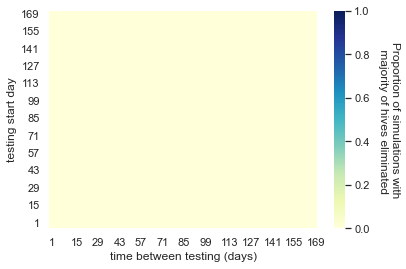

In [ ]:
# to generate figures 1 and 2, set weird_testing and figures_1_2 to 1
figure_1 = 0
figure_2 = 0

# to generate figures 3 and 4, set figures_3_4 to 1
figures_3_4_5 = 1

# defining parameter values 
t_end = 1000
if figure_2: # we only consider 1 hive in figure 2
  grid_size = 1
else:
  grid_size = 5
n_managed = grid_size**2
sim = 500 
testing_start = 50 #days?
time_between_testing = 30 #days
movement_prob = 0.01
test_sensitivity = 0.7


params = {'testing_start': testing_start,
          "time_between_testing": time_between_testing,
          'movement_prob': movement_prob,
          'test_sensitivity': test_sensitivity
        }

param_names = ['testing_start', 'time_between_testing', 'movement_prob', 'test_sensitivity']
param_ranges = [[0, 50, 80, 110, 140, 170, 200], [1, 30, 60, 90, 120, 150, 180], [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], np.arange(0.1, 1.1, 0.1)]
# param_names = ['testing_start']
# param_ranges = [[0, 50, 80, 110, 140, 170, 200]]
# default parameters for simulations 
standard_params = {'sim': sim,
                   't': t_end,
                   'n_managed': n_managed,
                   'grid_size': grid_size,
                   'neighbours': get_neighbours(grid_size),
                   'testing_start': testing_start,
                   'time_between_testing': time_between_testing,
                   'test_sensitivity': test_sensitivity,
                   'movement_prob': movement_prob
}

# generating figures 
if figure_1:
  # Figure 1a was generated using random seed = 12 and 1b using random seed = 1
  # Running the model without setting a seed will show how the dynamics change simulation to simulation 

  # Figure 1a
  np.random.seed(12)

  # generate data (1 simulation instance)
  total_mites, total_mites_out_of_brood, hives_eliminated, hives_infested, mites_when_testing_started, eliminated_hives, initial_hives = multiple_simulations(1, t_end, n_managed, grid_size, get_neighbours(grid_size),params)

  # plot data 
  grid_plotting(0,total_mites, grid_size, 'single_sim', time_between_testing, testing_start, eliminated_hives, initial_hives)

  # Figure 1b
  np.random.seed(1)
  
  # generate data (1 simulation instance)
  total_mites, total_mites_out_of_brood, hives_eliminated, hives_infested, mites_when_testing_started, eliminated_hives, initial_hives = multiple_simulations(1, t_end, n_managed, grid_size, get_neighbours(grid_size),params)

  # plot data 
  grid_plotting(0,total_mites, grid_size, 'single_sim', time_between_testing, testing_start, eliminated_hives, initial_hives)

if figure_2:
  # Figure 2 was generated using random seed = 8
  # Not choosing a seed will allow you to see how the probability of positive test result changes each simulation 
  np.random.seed(34)

  # generate data 
  total_managed_mites, total_mites_out_of_brood, managed_hives_eliminated, managed_hives_infested, mites_when_testing_started, eliminated_hives = total_model(0, t_end, n_managed, grid_size, get_neighbours(grid_size),params)

  # plot data
  plot_total_mites(total_managed_mites, total_mites_out_of_brood, n_managed, testing_start, time_between_testing)


if figures_3_4_5:
  # Figure 3: movement between hives 
  # Figure 4: Time between testing 
  # Figure 5: Test start day 

  # generate data 
  generate_data_figures_3_4(standard_params, param_names, param_ranges)

  # plotting data 
  data_files = ['Data/movement_prob_hives_eliminated.csv', 'Data/time_between_testing_hives_eliminated.csv', 'Data/testing_start_hives_eliminated.csv']
  file_names = ['movement.eps', 'time-between-testing.eps', 'test-start.eps']
  param_ranges = [[0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], [1, 30, 60, 90, 120, 150, 180], [0, 50, 80, 110, 140, 170, 200]]

  plot_data_figure_3_4_5a(data_files, param_ranges, n_managed, sim, 0, file_names)

  # generate_data_heatmap(standard_params)
  heatmapfiles = ['results/heatmap-'+ str(i) +'.csv' for i in range(1,170,7)]
  plot_heatmap(heatmapfiles, len(range(1,170,7)))

  plot_figure_6('test_sensitivity_hives_eliminated.csv',  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], n_managed, sim, 0, ['prop_mites_removed.eps', 'test_methods.eps'])